In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

from models.utils import detector_head, descriptor_head, detector_loss, descriptor_loss, model_metrics, box_nms
from utils.tools import dict_update

In [3]:
seed = 1

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/VLAD/oxford_dataset'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points, flat2mat, mat2flat)
from models.utils import box_nms

In [7]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [8]:
default_config = {
        'dataset': 'oxford',  # or 'coco'
        'alteration': 'all',  # 'all', 'i' for illumination or 'v' for viewpoint
        'cache_in_memory': False,
        'truncate': None,
        'preprocessing': {
            'resize': False
        }
    }

In [9]:
import yaml
with open('/root/Internship-Valeo/Project/configs/superpoint_oxford.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [10]:
config1 = config
config = dict_update(default_config, config['data'])

In [11]:
default_model_config = {
            'data_format': 'channels_last',
            'grid_size': 8,
            'detection_threshold': 0.4,
            'descriptor_size': 256,
            'batch_size': 32,
            'learning_rate': 0.001,
            'lambda_d': 250,
            'descriptor_size': 256,
            'positive_margin': 1,
            'negative_margin': 0.2,
            'lambda_loss': 0.0001,
            'nms': 0,
            'top_k': 0,
    }

In [12]:
model_config = dict_update(default_model_config, config1['model'])

In [13]:
model_config['data_format']

'channels_last'

In [14]:
def vgg_block(inputs, filters, kernel_size, name, data_format, training=False,
              batch_normalization=True, kernel_reg=0., **params):
    x = tfl.Convolution2D(filters, kernel_size,
                       kernel_regularizer=tf.keras.regularizers.L2(kernel_reg),
                       data_format=data_format, **params)(inputs)
    if batch_normalization:
        x = tfl.BatchNormalization(
                    fused=True,
                    axis=1 if data_format == 'channels_first' else -1)(x)
    return x

In [15]:
def shared_encoder(model_config, shape = (240, 320,1)):
    params_conv = {'padding': 'SAME', 'data_format': model_config['data_format'],
                   'batch_normalization': True, 'activation': tf.nn.relu,
                   'kernel_reg': model_config.get('kernel_reg', 0.)}
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel
    pool_size=(2, 2)
    kernel = 3
    inputs = Input(shape)
    # Encoder
    conv1 = vgg_block(inputs, 64, (kernel, kernel), 'conv1_1', **params_conv)
    conv2 = vgg_block(conv1, 64, (kernel, kernel), 'conv1_2', **params_conv)
    pool1 = MaxPooling2D(pool_size, name="block1_pool")(conv2)

    conv3 = vgg_block(pool1, 64, (kernel, kernel), 'conv2_1', **params_conv)
    conv4 = vgg_block(conv3, 64, (kernel, kernel), 'conv2_2', **params_conv)
    pool2 = MaxPooling2D(pool_size, name="block2_pool")(conv4)

    conv5 = vgg_block(pool2, 128, (kernel, kernel), 'conv3_1', **params_conv)
    conv6 = vgg_block(conv5, 128, (kernel, kernel), 'conv3_2', **params_conv)
    pool3 = MaxPooling2D(pool_size, name="block3_pool")(conv6)

    conv7 = vgg_block(pool3, 128, (kernel, kernel), 'conv4_1', **params_conv)
    conv8 = vgg_block(conv7, 128, (kernel, kernel), 'conv4_2', **params_conv)
    pool4 = MaxPooling2D(pool_size, name="block4_pool")(conv8)
    return keras.models.Model(inputs = inputs, outputs = {'pool4':pool4, 'conv8':conv8, 'conv7':conv7, 'conv6':conv6, 
                                                          'conv5':conv5, 'conv4':conv4, 'conv3':conv3, 
                                                          'conv2':conv2, 'conv1':conv1}, name = 'shared_encoder')

In [16]:
def segmentation_head(shape_pool4 = (15, 20, 128), shape_conv8 = (30, 40, 128),
                      shape_conv7 = (30, 40, 128), shape_conv6 = (60, 80, 128),
                      shape_conv5 = (60, 80, 128), shape_conv4 = (120, 160, 64),
                      shape_conv3 = (120, 160, 64), shape_conv2 = (240, 320, 64),
                      shape_conv1 = (240, 320, 64), kernel = 3):
    input_pool4 = Input(shape_pool4)
    input_conv8 = Input(shape_conv8)
    input_conv7 = Input(shape_conv7)
    input_conv6 = Input(shape_conv6)
    input_conv5 = Input(shape_conv5)
    input_conv4 = Input(shape_conv4)
    input_conv3 = Input(shape_conv3)
    input_conv2 = Input(shape_conv2)
    input_conv1 = Input(shape_conv1)
    
    conv9 = Conv2DTranspose(128, (kernel, kernel),strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(input_pool4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = concatenate( [input_conv8 , conv9]  , axis = -1)
    conv10 = Conv2DTranspose(128, (kernel, kernel), 
                              padding="same", kernel_initializer='he_uniform')(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation("relu")(conv10)
    conv10 = concatenate( [input_conv7 , conv10]  , axis = -1)


    conv11 = Conv2DTranspose(128, (kernel, kernel), strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation("relu")(conv11)
    conv11 = concatenate( [input_conv6 , conv11]  , axis = -1)
    
    conv12 = Conv2DTranspose(128, (kernel, kernel),padding="same", kernel_initializer='he_uniform')(conv11)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation("relu")(conv12)
    conv12 = concatenate( [input_conv5 , conv12]  , axis = -1)

    conv13 = Conv2DTranspose(64, (kernel, kernel),strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv12)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation("relu")(conv13)
    conv13 = concatenate( [input_conv4 , conv13]  , axis = -1)
    
    conv14 = Conv2DTranspose(64, (kernel, kernel), padding="same", kernel_initializer='he_uniform')(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation("relu")(conv14)
    conv14 = concatenate( [input_conv3 , conv14]  , axis = -1)


    conv15 = Conv2DTranspose(64, (kernel, kernel), strides=(2,2),
                              padding="same", kernel_initializer='he_uniform')(conv14)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation("relu")(conv15)
    conv15 = concatenate( [input_conv2 , conv15]  , axis = -1)
    
    conv16 = Conv2DTranspose(64, (kernel, kernel), padding="same", kernel_initializer='he_uniform')(conv15)
    conv16 = BatchNormalization()(conv16)
    conv16 = concatenate( [input_conv1 , conv16]  , axis = -1)
    
    conv17 = Conv2DTranspose(1, (1, 1), padding="same", kernel_initializer='he_uniform')(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('sigmoid')(conv17)
#     conv17 = Dense(1)(conv17)
#     output = Activation('softmax')(conv17)
    return keras.models.Model(inputs = {'pool4':input_pool4, 'conv8':input_conv8, 'conv7':input_conv7, 
                                        'conv6':input_conv6, 'conv5':input_conv5, 'conv4':input_conv4, 
                                        'conv3':input_conv3, 'conv2':input_conv2, 'conv1':input_conv1}, 
                              outputs = conv17, name = 'segmentation_head')

In [17]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            model_config = model_config)
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred)
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'detector_precision')
        self.add_metric(metrics['recall'], name = 'detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

class WarpedDetectorLossLayer(Layer):
    def __init__(self, name='warped_detector_loss_layer', trainable=False):
        super(WarpedDetectorLossLayer, self).__init__(name = name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(keypoint_map = inputs[0], logits = inputs[1]['logits'], 
                            valid_mask = inputs[2], model_config = model_config)
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'warped_detector_precision')
        self.add_metric(metrics['recall'], name = 'warped_detector_recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

In [18]:
class SemanticsLossLayer(Layer):
    def __init__(self, name='semantics_loss_layer', trainable=False):
        super(SemanticsLossLayer, self).__init__(name = name)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.accuracy_fn = tf.keras.metrics.BinaryAccuracy()

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1])
        accuracy = self.accuracy_fn(inputs[0], inputs[1])
        self.add_loss(loss)
        self.add_metric(accuracy)
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

In [19]:
class WarpedSemanticsLossLayer(Layer):
    def __init__(self, name='warped_semantics_loss_layer', trainable=False):
        super(WarpedSemanticsLossLayer, self).__init__(name = name)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.accuracy_fn = tf.keras.metrics.BinaryAccuracy()

    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], tf.expand_dims(inputs[1], axis = 2)*inputs[2])
        accuracy = self.accuracy_fn(inputs[0], tf.expand_dims(inputs[1], axis = 2)*inputs[2])
        self.add_loss(loss)
        self.add_metric(accuracy)
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

In [20]:
class HomographyLayer(Layer):
    def call(self, inputs):
        return inputs

def HomographyModel(shape = (8,)):
    x = Input(shape)
    output = HomographyLayer(name="homography_layer", trainable=False)(x)
    return keras.models.Model(inputs = x, outputs = output)

class DescriptorLossLayer(Layer):
    def __init__(self, name='descriptor_loss_layer', trainable=False):
        super(DescriptorLossLayer, self).__init__(name=name)
        self.loss_fn = descriptor_loss
#         self.accuracy_fn = keras.metrics.BinaryAccuracy(name="accuracy")

    def call(self, inputs, targets=None, sample_weight=None):
        loss = model_config['lambda_loss'] * self.loss_fn(descriptors = inputs[0], 
                                                          warped_descriptors = inputs[1],
                            homographies = inputs[2], valid_mask = inputs[3], **model_config)
        self.add_loss(loss)
#         return tf.reshape(loss, (1,))
        return loss
    def compute_output_shape(self, input_shape):
        return [1]
    
def net():
    
#     images_input = Input(shape = (240, 320,1), name = 'images_input')
#     points_list_input = Input(shape = (240, 320), name = 'points_input') 
#     homography_list_input = Input(shape = (8,), name = 'homography_list_input') 
#     warped_images_input = Input(shape = (240, 320,1), name = 'warped_images_input')
#     valid_masks_input = Input(shape = (240, 320), name = 'valid_masks_input')
#     warped_points_list_input = Input(shape = (240, 320), name = 'warped_points_input')
    
    
    inputs = {'image':Input(shape = (240, 320, 1), name = 'image'),
              'name': Input(shape = (None,1), name = 'name'),
              'keypoints':Input(shape = (240,320), name = 'keypoints'),              
              'valid_mask':Input(shape = (240,320), name = 'valid_mask'),
              'mask_image':Input(shape = (240, 320, 1), name = 'mask_image'),
              'warped':{
                  'image':Input(shape = (240, 320, 1), name = 'warped_image'),
                  'name': Input(shape = (None,1), name = 'warped_name'),
                  'keypoints':Input(shape = (240, 320), name = 'warped_keypoints'),
                  'valid_mask':Input(shape = (240, 320), name = 'warped_valid_mask'),
                  'mask_image':Input(shape = (240, 320, 1), name = 'warped_mask_image'),
                  'homography':Input(shape = (8,), name = 'homography'),
               }}
    
    homography_model = HomographyModel()
#     homography = homography_model(homography_list_input)
    homography = homography_model(inputs['warped']['homography'])
    
    encoder = shared_encoder(shape = (240, 320, 1), model_config = model_config)
#     encoder_output = encoder(images_input)
#     warped_encoder_output = encoder(warped_images_input)
    encoder_output = encoder(inputs['image'])
    warped_encoder_output = encoder(inputs['warped']['image'])
    
    detector = detector_head(shape = (30, 40, 128), model_config = model_config)
    detector_output = detector(encoder_output['conv8'])
    warped_detector_output = detector(warped_encoder_output['conv8'])
    
    descriptor = descriptor_head(shape = (30, 40, 128), model_config=model_config)
    descriptor_output = descriptor(encoder_output['conv8'])
    warped_descriptor_output = descriptor(warped_encoder_output['conv8'])
    
    semantics_model = segmentation_head()
    semantics_output = semantics_model(encoder_output)
    warped_semantics_output = semantics_model(warped_encoder_output)
    
#     detector_loss_layer = DetectorLossLayer()([points_list_input, detector_output])
    detector_loss_layer = DetectorLossLayer()([inputs['keypoints'],
                                                 detector_output])
    
#     warped_detector_loss_layer = WarpedDetectorLossLayer()([warped_points_list_input, 
#                                                 warped_detector_output, 
#                                                       valid_masks_input])

    warped_detector_loss_layer = WarpedDetectorLossLayer()([inputs['warped']['keypoints'], 
                                                warped_detector_output, 
                                                      inputs['warped']['valid_mask']])
    
#     descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
#                                         warped_descriptor_output['descriptors_raw'], 
#                                           homography, valid_masks_input])

    descriptor_loss_layer = DescriptorLossLayer()([descriptor_output['descriptors_raw'],
                                                   warped_descriptor_output['descriptors_raw'], 
                                          inputs['warped']['homography'], inputs['warped']['valid_mask']])
    
    semantics_loss_layer = SemanticsLossLayer()([inputs['mask_image'], semantics_output])
    
    warped_semantics_loss_layer = WarpedSemanticsLossLayer()([inputs['warped']['mask_image'], 
                                                        inputs['warped']['valid_mask'],
                                                              warped_semantics_output])
    
    model = keras.models.Model(inputs = inputs,#[images_input, points_list_input, homography_list_input, 
                                         #warped_images_input, valid_masks_input, warped_points_list_input],
                               outputs = [detector_loss_layer, warped_detector_loss_layer, 
                                          descriptor_loss_layer, semantics_loss_layer, 
                                          warped_semantics_loss_layer])
    return model

In [21]:
model = net()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


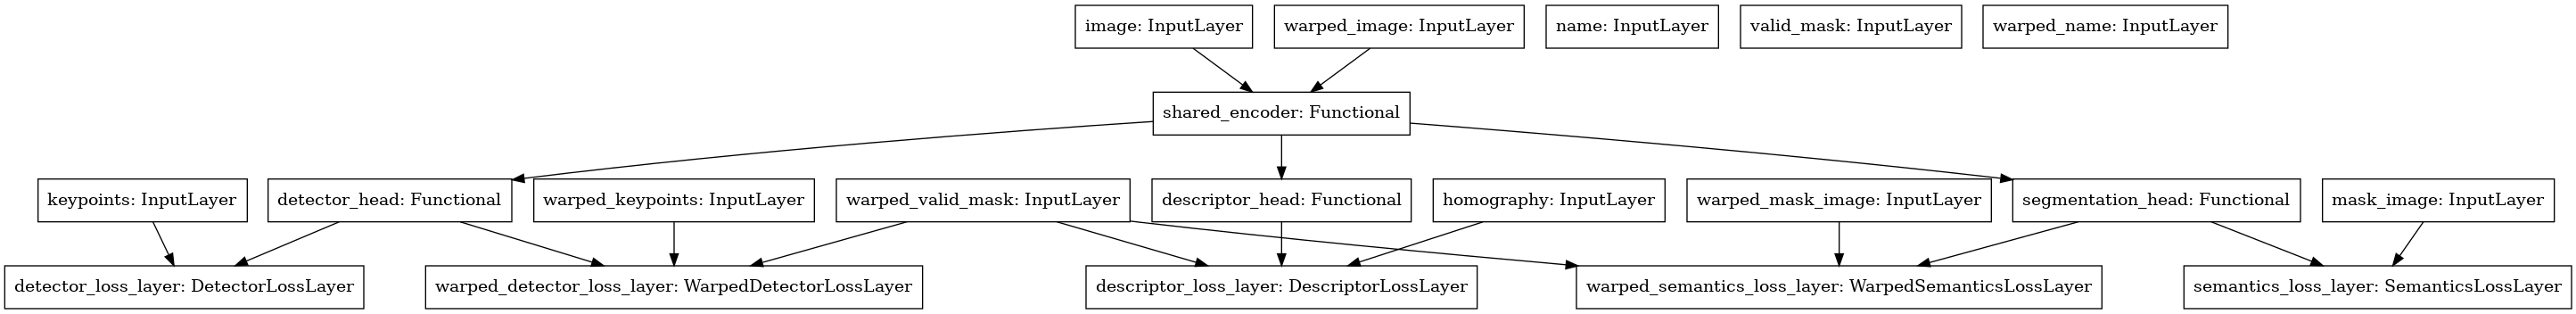

In [22]:
# model.summary()
keras.utils.plot_model(model, to_file="model.png", show_shapes = False, show_dtype=False, show_layer_names=True,
    rankdir="TB", expand_nested=False, dpi=96)

In [23]:
# model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-mtl-coco-090822')
model.load_weights('/root/Internship-Valeo/Project/results/checkpoint-mtl-kitti360-250822')

In [24]:
# # Make changes here for illumination vs viewpoint

# config['alteration'] = 'i'

In [25]:
# # Make changes here for illumination vs viewpoint

# # output_dir = '/root/Internship-Valeo/Project/exports/superpoint_hpatches-i'
# output_dir = '/root/Internship-Valeo/Project/exports/mtl_hpatches-i'

In [26]:
from keras.models import Model

model = model # include here your original model

In [27]:
# model.input

In [28]:
# descriptor_model = Model(inputs=[model.input['image'], model.input['warped']['image']],                                 
#                          outputs=model.get_layer('descriptor_loss_layer').input[0:2])

In [29]:
# model.get_layer('descriptor_loss_layer').input

In [30]:
# detector_model = Model(inputs=[model.input['image'], model.input['warped']['image']],                                 
#                          outputs=[model.get_layer('detector_loss_layer').input[1]['prob'], 
#                                   model.get_layer('warped_detector_loss_layer').input[1]['prob']])

In [31]:
# model.get_layer('detector_loss_layer').input

In [32]:
# model.get_layer('warped_detector_loss_layer').input

In [33]:
# logits = model.get_layer('detector_loss_layer').input[1]['logits']
# warped_logits = model.get_layer('warped_detector_loss_layer').input[1]['logits']
# pred_mask = model.get_layer('semantics_loss_layer').input[1]
# warped_pred_mask = model.get_layer('warped_semantics_loss_layer').input[2]
# m1 = keras.models.Model(inputs = [model.input['image'], model.input['warped']['image']], 
#                         outputs = [logits, warped_logits, pred_mask, warped_pred_mask])

In [34]:
# model.get_layer('semantics_loss_layer').input

In [35]:
cfirst = model_config['data_format'] == 'channels_first'
cindex = 1 if cfirst else -1  # index of the channel

In [36]:
from datasets import oxford
data = oxford.OxfordDataset()
files = data._init_dataset(**config)
# train_gen = data._get_data(files, 'training', **config)
# train_gen = train_gen.batch(5)
val_gen = data._get_data(files, 'validation', **config)
# val_gen = val_gen.batch(5)

In [37]:
# from tqdm import tqdm
# val_gen = val_gen.batch(1)
# x = iter(val_gen)

# pbar = tqdm(total=config1['eval_iter'] if config1['eval_iter'] > 0 else None)
# i = 0
# while True:
#     try:
#         data = x.get_next()
#     except data.end_set:
#         break
#     data1 = {'image': data['image'][0]}
#     data2 = {'image': data['warped_image'][0]}
#     m1_pred = m1.predict(data)
#     z = tf.nn.space_to_depth(m1_pred[2], model_config['grid_size'])
#     shape = tf.concat([tf.shape(z)[:3], [1]], axis=0)
#     z = tf.concat([2*z, tf.ones(shape)], 3)
#     w = m1_pred[0]*z
#     w = tf.nn.softmax(w, axis=cindex)
#     # Strip the extra “no interest point” dustbin
#     w = w[:, :-1, :, :] if cfirst else w[:, :, :, :-1]
#     w = tf.nn.depth_to_space(w, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     w = tf.squeeze(w, axis=cindex)
#     if model_config['nms']:
#         prob1 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
#                                                min_prob=model_config['detection_threshold'],
#                                                keep_top_k=model_config['top_k']), w)
#     p1 = tf.cast(tf.greater_equal(prob1, model_config['detection_threshold']), tf.int32)
#     kp1 = {'keypoint_map': [np.array(np.where(e)).T for e in p1]}
    

#     z = tf.nn.space_to_depth(m1_pred[3], model_config['grid_size'])
#     shape = tf.concat([tf.shape(z)[:3], [1]], axis=0)
#     z = tf.concat([2*z, tf.ones(shape)], 3)
#     w = m1_pred[1]*z
#     w = tf.nn.softmax(w, axis=cindex)
#     # Strip the extra “no interest point” dustbin
#     w = w[:, :-1, :, :] if cfirst else w[:, :, :, :-1]
#     w = tf.nn.depth_to_space(w, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     w = tf.squeeze(w, axis=cindex)
#     if model_config['nms']:
#         prob2 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
#                                                min_prob=model_config['detection_threshold'],
#                                                keep_top_k=model_config['top_k']), w)
#     p2 = tf.cast(tf.greater_equal(prob2, model_config['detection_threshold']), tf.int32)
#     kp2 = {'keypoint_map': [np.array(np.where(e)).T for e in p2]}
    
    
    
#     descriptor_output = descriptor_model.predict(data)    
    
#     y = descriptor_output[0]
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel

#     desc1 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
#     desc1 = tf.image.resize(
#             desc1, model_config['grid_size'] * tf.shape(desc1)[1:3], method='bilinear')
#     desc1 = tf.transpose(desc1, [0, 3, 1, 2]) if cfirst else desc1
#     desc1 = tf.nn.l2_normalize(desc1, cindex)
    
#     pred1 = desc1
    
#     y = descriptor_output[1]
#     desc2 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
#     desc2 = tf.image.resize(
#             desc2, model_config['grid_size'] * tf.shape(desc2)[1:3], method='bilinear')
#     desc2 = tf.transpose(desc2, [0, 3, 1, 2]) if cfirst else desc2
#     desc2 = tf.nn.l2_normalize(desc2, cindex)
    
#     pred2 = desc2
    
#     pred = {'image': data['image'][0],
#             'warped_image': data['warped_image'][0],
#             'prob': prob1[0],
#                     'warped_prob': prob2[0],
#                     'desc': pred1[0],
#                     'warped_desc': pred2[0],
#                     'homography': data['homography'][0],
#                     'keypoint_map': kp1['keypoint_map'][0],
#                     'warped_keypoint_map': kp2['keypoint_map'][0]   }

# #     if not ('name' in data):
# #         pred.update(data)
#     filename = data['name'][0].decode('utf-8') if 'name' in data else str(i)
#     filepath = Path(output_dir, '{}.npz'.format(filename))
#     np.savez_compressed(filepath, **pred)
#     i += 1
#     pbar.update(1)
#     if i == config1['eval_iter']:
#         break

In [38]:
descriptor_model1 = Model(inputs=model.input['image'],                                 
                         outputs=model.get_layer('descriptor_loss_layer').input[0])

In [39]:
logits = model.get_layer('detector_loss_layer').input[1]['logits']

pred_mask = model.get_layer('semantics_loss_layer').input[1]

m2 = keras.models.Model(inputs = model.input['image'], 
                        outputs = [logits, pred_mask])

In [40]:
path = '/root/Internship-Valeo/Project/VLAD/oxford_dataset/oxbuild_images-v1'

# Semantic Descriptors

In [41]:
# import itertools
# from tqdm import tqdm
# val_gen = val_gen.batch(1)
# x = iter(val_gen)

# pbar = tqdm(total=config1['eval_iter'] if config1['eval_iter'] > 0 else None)
# i = 0
# descriptors=list()
# while True:
#     try:
#         data = x.get_next()
#     except data.end_set:
#         break
#     descriptor_output = descriptor_model1.predict(data['image'])
#     y = descriptor_output
#     cfirst = model_config['data_format'] == 'channels_first'
#     cindex = 1 if cfirst else -1  # index of the channel

#     desc1 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
#     desc1 = tf.image.resize(
#             desc1, model_config['grid_size'] * tf.shape(desc1)[1:3], method='bilinear')
#     desc1 = tf.transpose(desc1, [0, 3, 1, 2]) if cfirst else desc1
#     desc1 = tf.nn.l2_normalize(desc1, cindex)
    
#     m2_pred = m2.predict(data['image'])
    
# #     z = tf.nn.space_to_depth(m2_pred[1], model_config['grid_size'])
# #     shape = tf.concat([tf.shape(z)[:3], [1]], axis=0)
# #     z = tf.concat([2*z, tf.ones(shape)], 3)
# #     w = m2_pred[0]*z
#     w = m2_pred[0]
#     w = tf.nn.softmax(w, axis=cindex)
#     # Strip the extra “no interest point” dustbin
#     w = w[:, :-1, :, :] if cfirst else w[:, :, :, :-1]
#     w = tf.nn.depth_to_space(w, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
#     w = tf.squeeze(w, axis=cindex)
#     if model_config['nms']:
#         prob1 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
#                                                min_prob=model_config['detection_threshold'],
#                                                keep_top_k=model_config['top_k']), w)
#     p1 = tf.cast(tf.greater_equal(prob1, model_config['detection_threshold']), tf.int32)
#     kp1 = {'keypoint_map': [np.array(np.where(e)).T for e in p1]}
    
    
#     xy = np.zeros((len(kp1['keypoint_map'][0]),256))
#     i = 0
#     for kp in kp1['keypoint_map'][0]:
#         a = kp[0]
#         b = kp[1]
#         xy[i] = desc1[0][(a,b)]
#         i=i+1
#     descriptors.append(xy)

In [42]:
# len(descriptors)

In [43]:
# #flatten list       
# descriptors = list(itertools.chain.from_iterable(descriptors))
# #list to array
# descriptors = np.asarray(descriptors)
# import pickle
# output =  '/root/Internship-Valeo/Project/VLAD/descriptors/descriptorSP'
# #writting the output
# file=output+".pickle"

# with open(file, 'wb') as f:
#     pickle.dump(descriptors, f, protocol=4)

In [44]:
pathVD = '/root/Internship-Valeo/Project/VLAD/visualDictionary/visualDictionary256MTL.pickle'
outputVLAD = '/root/Internship-Valeo/Project/VLAD/VLADdescriptors/VLAD_MTL_W256'

In [45]:
import pickle
with open(pathVD, 'rb') as f:
    visualDictionary=pickle.load(f) 

In [46]:
def VLAD(X,visualDictionary):

    predictedLabels = visualDictionary.predict(X)
    centers = visualDictionary.cluster_centers_
    labels=visualDictionary.labels_
    k=visualDictionary.n_clusters
   
    m,d = X.shape
    V=np.zeros([k,d])
    #computing the differences

    # for all the clusters (visual words)
    for i in range(k):
        # if there is at least one descriptor in that cluster
        if np.sum(predictedLabels==i)>0:
            # add the diferences
            V[i]=np.sum(X[predictedLabels==i,:]-centers[i],axis=0)
    

    V = V.flatten()
    # power normalization, also called square-rooting normalization
    V = np.sign(V)*np.sqrt(np.abs(V))

    # L2 normalization

    V = V/np.sqrt(np.dot(V,V))
    return V

In [47]:
# Computing VLAD Descriptors
vladDescriptors=list()
idImage =list()
import itertools
from tqdm import tqdm
val_gen = val_gen.batch(1)
x = iter(val_gen)

pbar = tqdm(total=config1['eval_iter'] if config1['eval_iter'] > 0 else None)
i = 0

while True:
    try:
        data = x.get_next()
    except data.end_set:
        break
    descriptor_output = descriptor_model1.predict(data['image'])
    y = descriptor_output
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    desc1 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
    desc1 = tf.image.resize(
            desc1, model_config['grid_size'] * tf.shape(desc1)[1:3], method='bilinear')
    desc1 = tf.transpose(desc1, [0, 3, 1, 2]) if cfirst else desc1
    desc1 = tf.nn.l2_normalize(desc1, cindex)
    
    m2_pred = m2.predict(data['image'])
    
    z = tf.nn.space_to_depth(m2_pred[1], model_config['grid_size'])
    shape = tf.concat([tf.shape(z)[:3], [1]], axis=0)
    z = tf.concat([2*z, tf.ones(shape)], 3)
    w = m2_pred[0]*z
#     w = m2_pred[0]
    w = tf.nn.softmax(w, axis=cindex)
    # Strip the extra “no interest point” dustbin
    w = w[:, :-1, :, :] if cfirst else w[:, :, :, :-1]
    w = tf.nn.depth_to_space(w, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    w = tf.squeeze(w, axis=cindex)
    if model_config['nms']:
        prob1 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), w)
    p1 = tf.cast(tf.greater_equal(prob1, model_config['detection_threshold']), tf.int32)
    kp1 = {'keypoint_map': [np.array(np.where(e)).T for e in p1]}
    
    
    des = np.zeros((len(kp1['keypoint_map'][0]),256))
    i = 0
    for kp in kp1['keypoint_map'][0]:
        a = kp[0]
        b = kp[1]
        des[i] = desc1[0][(a,b)]
        i=i+1    
    if len(kp1['keypoint_map'][0])!=0:
        v=VLAD(des,visualDictionary)
        vladDescriptors.append(v)
        idImage.append(data['name'])
                    
#list to array    
vladDescriptors = np.asarray(vladDescriptors)

  0%|          | 0/6000 [00:00<?, ?it/s]

AttributeError: 'dict' object has no attribute 'end_set'

In [48]:
#writting the output
file=outputVLAD+".pickle"

with open(file, 'wb') as f:
    pickle.dump([idImage, vladDescriptors, path], f, protocol=4)

In [49]:
len(vladDescriptors)

5063

In [50]:
def query(image, k, visualDictionary,tree):
#     #read image   
#     im = cv2.imread(imagePath, 0)
#     im = cv2.resize(im, (320,240))
#     im = np.expand_dims(im, axis = 0)
#     im = np.expand_dims(im, axis = 3)
    #compute descriptors
    descriptor_output = descriptor_model1(image)
    y = descriptor_output
    cfirst = model_config['data_format'] == 'channels_first'
    cindex = 1 if cfirst else -1  # index of the channel

    desc1 = tf.transpose(y, [0, 2, 3, 1]) if cfirst else y
    desc1 = tf.image.resize(
            desc1, model_config['grid_size'] * tf.shape(desc1)[1:3], method='bilinear')
    desc1 = tf.transpose(desc1, [0, 3, 1, 2]) if cfirst else desc1
    desc1 = tf.nn.l2_normalize(desc1, cindex)
    
    m2_pred = m2.predict(image)
    
    z = tf.nn.space_to_depth(m2_pred[1], model_config['grid_size'])
    shape = tf.concat([tf.shape(z)[:3], [1]], axis=0)
    z = tf.concat([2*z, tf.ones(shape)], 3)
    w = m2_pred[0]*z
#     w = m2_pred[0]
    w = tf.nn.softmax(w, axis=cindex)
    # Strip the extra “no interest point” dustbin
    w = w[:, :-1, :, :] if cfirst else w[:, :, :, :-1]
    w = tf.nn.depth_to_space(w, model_config['grid_size'], data_format='NCHW' if cfirst else 'NHWC')
    w = tf.squeeze(w, axis=cindex)
    if model_config['nms']:
        prob1 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), w)
    p1 = tf.cast(tf.greater_equal(prob1, model_config['detection_threshold']), tf.int32)
    kp1 = {'keypoint_map': [np.array(np.where(e)).T for e in p1]}
    
    
    des = np.zeros((len(kp1['keypoint_map'][0]),256))
    i = 0
    for kp in kp1['keypoint_map'][0]:
        a = kp[0]
        b = kp[1]
        des[i] = desc1[0][(a,b)]
        i=i+1        

    #compute VLAD
    v=VLAD(des,visualDictionary)

    #find the k most relevant images
    dist, ind = tree.query(v.reshape(1, -1), k)    

    return dist, ind

In [51]:
treeIndex = '/root/Internship-Valeo/Project/VLAD/ballTreeIndexes/index_MTL_W256.pickle'
with open(treeIndex, 'rb') as f:
    indexStructure=pickle.load(f)
imageID=indexStructure[0]
tree = indexStructure[1]
pathImageData = indexStructure[2]

In [52]:
from datasets import oxfordQuery
data = oxfordQuery.OxfordQueryDataset()
files = data._init_dataset(**config)
# train_gen = data._get_data(files, 'training', **config)
# train_gen = train_gen.batch(5)
val_gen = data._get_data(files, 'validation', **config)
val_gen = val_gen.batch(1)

In [53]:
# display the query
# imageQuery=cv2.imread(imagePath)
x = iter(val_gen)

In [56]:
data = x.get_next()

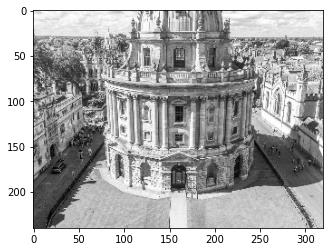

In [57]:
plt.imshow(data['image'][0], 'gray')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['name'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


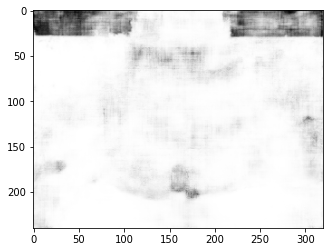

In [58]:
plt.imshow(m2.predict(data)[1][0], 'gray')

In [77]:
# imagePath = '/root/Internship-Valeo/Project/VLAD/queries/birds_eye_view_of_radcliffe_camera_oxford_england_vb34172101.jpg'
#imagePath = '/root/Internship-Valeo/Project/VLAD/oxford_dataset/oxbuild_images-v1/all_souls_000002.jpg'
#imagePath = '/root/Internship-Valeo/Project/VLAD/oxford_dataset/oxbuild_images-v1/ashmolean_000129.jpg'
dist, ind = query(data['image'], 20, visualDictionary, tree)

In [78]:
print(dist)

[[1.26424693 1.30366927 1.30642403 1.31142674 1.31975339 1.32013503
  1.32431804 1.32496612 1.32536192 1.32580671 1.32607457 1.32777636
  1.32905317 1.33062507 1.33110107 1.33177232 1.33384098 1.33453286
  1.3346602  1.33562876]]


In [98]:
print(ind)

[[ 855 1427  599 3708 3261 4514 3923 4475 2587  220   62]]


In [79]:
print(ind)

[[ 855  599   62 1427 3261 4475 4514 3923 1078 3708 4796 3733 1192 2587
  1064 2521 4549 1770 3401 2534]]


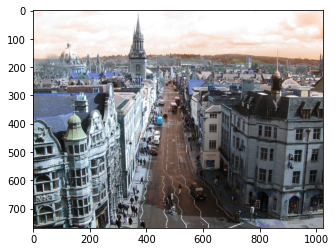

In [88]:
filename = (imageID[2534])[0]
im = Path(path,'{}.jpg'.format(filename.numpy().decode('utf-8')))
result = cv2.imread(str(im))
plt.imshow(result)